Tracks after filtering: 20
   track_index  lifetime  max_size_points  mean_size_points  merges_total  \
0           17         5            327.0        128.000000             1   
1           22         5            282.0        155.399994             0   
2           23         9           2357.0       1421.555542             3   
3           30         6           4954.0       4317.333496             1   
4           37         9           1210.0        628.000000             1   

   splits_total  mass_flux_metric merge_class  merged_flag  
0             1        1171559.00           1         True  
1             1         949939.75           0        False  
2             2       20045566.00          3+         True  
3             2       41566696.00           1         True  
4             1        8870920.00           1         True  


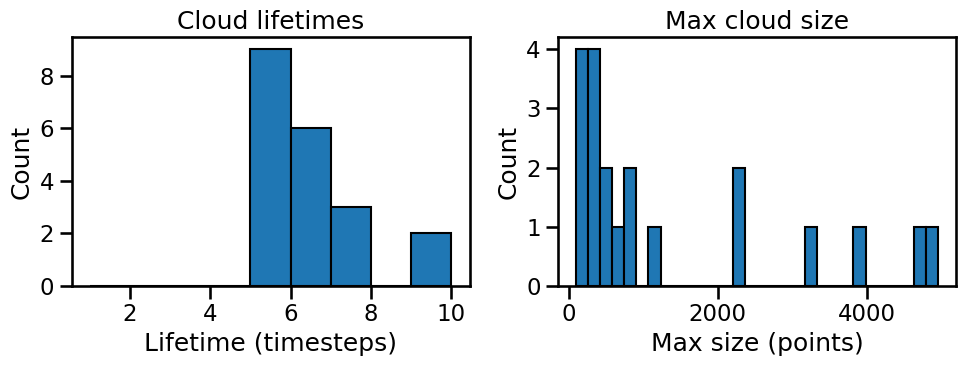

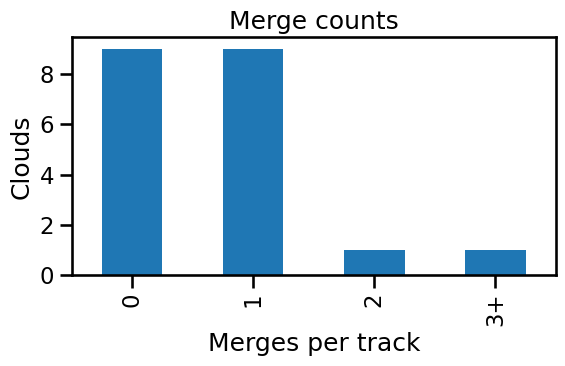

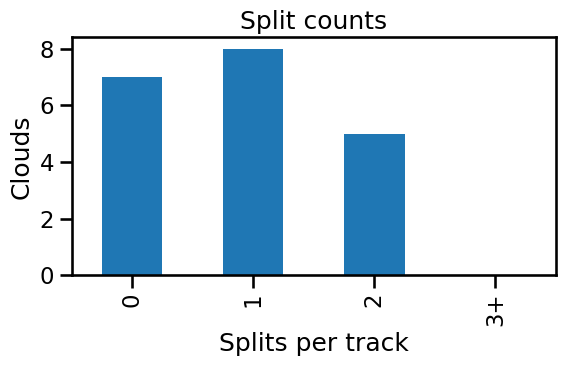

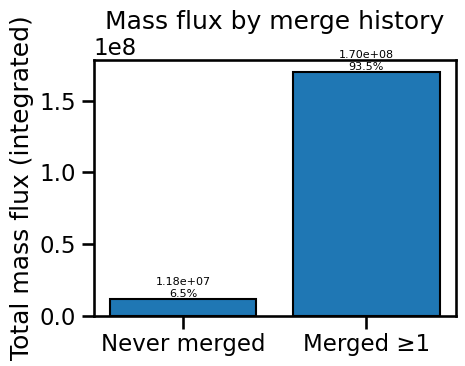

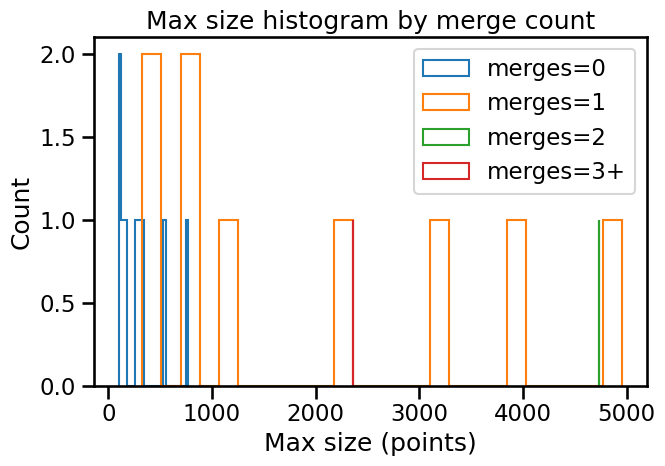

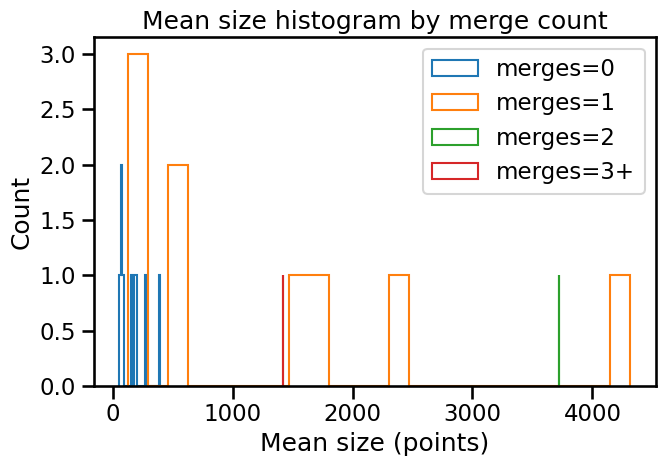

In [12]:
# PARAMETERS
nc_file = "../cloud_results.nc"
min_max_size_points = 10        # Track must reach at least this many voxels once
min_lifetime_steps = 5        # Track must exist (non-NaN size) at least this many timesteps
use_integrated_mass_flux = True  # If True: sum over time; else: time-mean
time_step_seconds = 60           # Needed only if you want to scale integrated flux by dt
volume_dx = 25.0                 # Horizontal grid (m)
volume_dy = 25.0                 # Horizontal grid (m)
# For voxel vertical thickness we infer per level (variable height spacing allowed)

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns
sns.set_context("talk")


# ---------------- Core extraction & processing ---------------- #
def load_tracks(nc_path):
    def read_opt(ds, name):
        var = ds.variables.get(name)
        return np.ma.filled(var[:], np.nan) if var is not None else None
    with Dataset(nc_path) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        height = np.asarray(ds.variables['height'][:])

        # optionals (properly sliced)
        cloud_base_area = read_opt(ds, 'cloud_base_area')
        max_height = read_opt(ds, 'max_height')
        cloud_base_height = read_opt(ds, 'cloud_base_height')
        base_radius_diagnosed = read_opt(ds, 'base_radius_diagnosed')
        base_radius_prescribed = read_opt(ds, 'base_radius_prescribed')
        max_w_cloud_base = read_opt(ds, 'max_w_cloud_base')
        w_per_level = read_opt(ds, 'w_per_level')  # (track,time,level)

    return dict(
        valid_track=valid_track,
        size=size,
        mass_flux=mass_flux,
        merges_count=merges_count.astype(np.int32),
        splits_count=splits_count.astype(np.int32),
        height=height,
        cloud_base_area=cloud_base_area,
        max_height=max_height,
        cloud_base_height=cloud_base_height,
        base_radius_diagnosed=base_radius_diagnosed,
        base_radius_prescribed=base_radius_prescribed,
        max_w_cloud_base=max_w_cloud_base,
        w_per_level=w_per_level,
    )






def build_track_dataframe(data, min_max_size_points, min_lifetime_steps,
                          use_integrated_mass_flux, time_step_seconds,
                          voxel_volume_per_level=None):
    valid_mask = data['valid_track'] == 1
    size = np.asarray(data['size'])                  # already filled
    mass_flux = np.asarray(data['mass_flux'])
    merges = np.asarray(data['merges_count'])
    splits = np.asarray(data['splits_count'])

    n_tracks, n_time = size.shape
    records = []
    for i in range(n_tracks):
        if not valid_mask[i]:
            continue

        size_row = size[i]  # (time,)
        # timesteps where size is real (not NaN and >0)
        valid_timesteps = np.isfinite(size_row)
        lifetime = int(valid_timesteps.sum())
        if lifetime == 0:
            continue

        max_size = np.nanmax(size_row)
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue

        # Safe sums (arrays are plain ndarrays now)
        merges_total = int(merges[i, valid_timesteps].sum())
        splits_total = int(splits[i, valid_timesteps].sum())

        mf_row = mass_flux[i]
        if use_integrated_mass_flux:
            mf_val = np.nansum(mf_row[valid_timesteps])  # * time_step_seconds if physical time integration needed
        else:
            mf_val = float(np.nanmean(mf_row[valid_timesteps]))

        mean_size = float(np.nanmean(size_row[valid_timesteps]))

        records.append(dict(track_index=i,
                            lifetime=lifetime,
                            max_size_points=max_size,
                            mean_size_points=mean_size,
                            merges_total=merges_total,
                            splits_total=splits_total,
                            mass_flux_metric=mf_val))
    return pd.DataFrame.from_records(records)


def infer_voxel_volumes(height, dx, dy):
    # Derive per-level thickness (Δz). Last level thickness = median of previous (fallback)
    z = np.asarray(height, dtype=float)
    if z.size < 2:
        dz = np.array([1.0])
    else:
        dz_mid = np.diff(z)
        last = np.median(dz_mid)
        dz = np.concatenate([dz_mid, [last]])
    # Return per-level voxel volume (m3)
    return dx * dy * dz


def categorize_merges(df):
    def cat(m):
        if m == 0: return "0"
        if m == 1: return "1"
        if m == 2: return "2"
        return "3+"
    return df.assign(merge_class=df.merges_total.map(cat),
                     merged_flag=(df.merges_total > 0))



# Remove the density plots: plot_size_distributions

# ---------------- Plotting helpers ---------------- #
def plot_basic_histograms(df):
    """Basic histograms of lifetimes and max sizes."""
    if df.empty:
        print("No tracks after filtering.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    life_max = int(df.lifetime.max())
    axes[0].hist(df.lifetime, bins=range(1, life_max + 2), edgecolor='black')
    axes[0].set_xlabel("Lifetime (timesteps)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Cloud lifetimes")
    axes[1].hist(df.max_size_points, bins=30, edgecolor='black')
    axes[1].set_xlabel("Max size (points)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Max cloud size")
    plt.tight_layout()

def plot_merge_frequency_counts(df):
    counts = df['merge_class'].value_counts().reindex(["0","1","2","3+"], fill_value=0)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.ylabel("Clouds")
    plt.xlabel("Merges per track")
    plt.title("Merge counts")
    plt.tight_layout()

def plot_split_frequency_counts(df):
    def scat(s):
        if s == 0: return "0"
        if s == 1: return "1"
        if s == 2: return "2"
        return "3+"
    counts = df.splits_total.map(scat).value_counts().reindex(["0","1","2","3+"], fill_value=0)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.ylabel("Clouds")
    plt.xlabel("Splits per track")
    plt.title("Split counts")
    plt.tight_layout()

def plot_mass_flux_by_merge_category(df):
    grp = df.groupby('merged_flag')['mass_flux_metric'].sum().reindex([False, True], fill_value=0)
    labels = ['Never merged','Merged ≥1']
    plt.figure(figsize=(5,4))
    plt.bar(labels, grp.values, edgecolor='black')
    plt.ylabel("Total mass flux" + (" (integrated)" if use_integrated_mass_flux else " (mean)"))
    plt.title("Mass flux by merge history")
    if grp.values.sum() > 0:
        pct = 100 * grp.values / grp.values.sum()
        for i,(v,p) in enumerate(zip(grp.values, pct)):
            plt.text(i, v, f"{v:.2e}\n{p:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.tight_layout()

def plot_size_histogram(df, which='max', bins=30, log=False):
    metric = 'max_size_points' if which=='max' else 'mean_size_points'
    plt.figure(figsize=(7,5))
    order = ["0","1","2","3+"]
    for cls in order:
        subset = df[df.merge_class == cls][metric]
        if subset.empty: 
            continue
        plt.hist(subset, bins=bins, histtype='step', label=f"merges={cls}", log=log)
    plt.xlabel(f"{which.capitalize()} size (points)")
    plt.ylabel("Count" + (" (log)" if log else ""))
    plt.title(f"{which.capitalize()} size histogram by merge count")
    plt.legend()
    plt.tight_layout()

# ---------------- Run pipeline ---------------- #
raw = load_tracks(nc_file)
voxel_vol = infer_voxel_volumes(raw['height'], volume_dx, volume_dy)  # still optional

df_tracks = build_track_dataframe(raw,
                                  min_max_size_points=min_max_size_points,
                                  min_lifetime_steps=min_lifetime_steps,
                                  use_integrated_mass_flux=use_integrated_mass_flux,
                                  time_step_seconds=time_step_seconds)

df_tracks = categorize_merges(df_tracks)

print(f"Tracks after filtering: {len(df_tracks)}")
print(df_tracks.head())

# Basic overview histograms first
plot_basic_histograms(df_tracks)

# Other summaries
plot_merge_frequency_counts(df_tracks)
plot_split_frequency_counts(df_tracks)
plot_mass_flux_by_merge_category(df_tracks)
plot_size_histogram(df_tracks, which='max', bins=25, log=False)
plot_size_histogram(df_tracks, which='mean', bins=25, log=False)
plt.show()

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_9031/1259573898.py:25: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(arr[idx, :], axis=1)


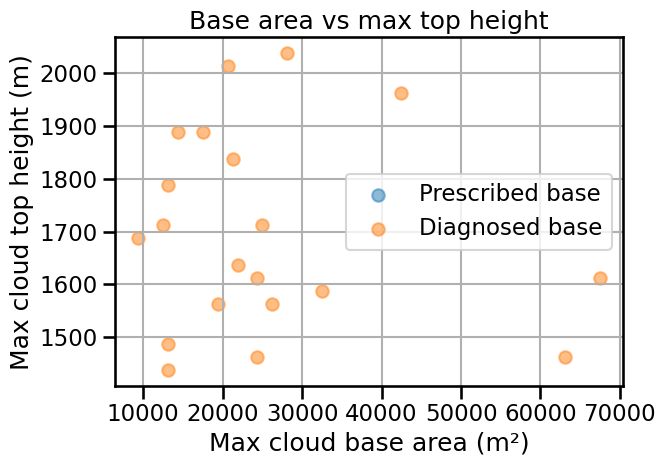

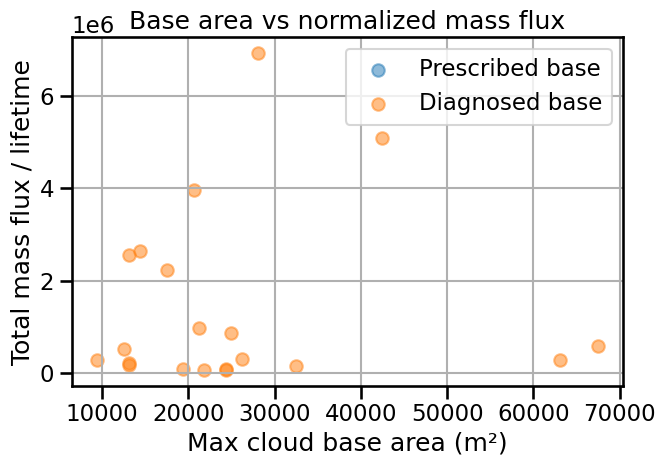

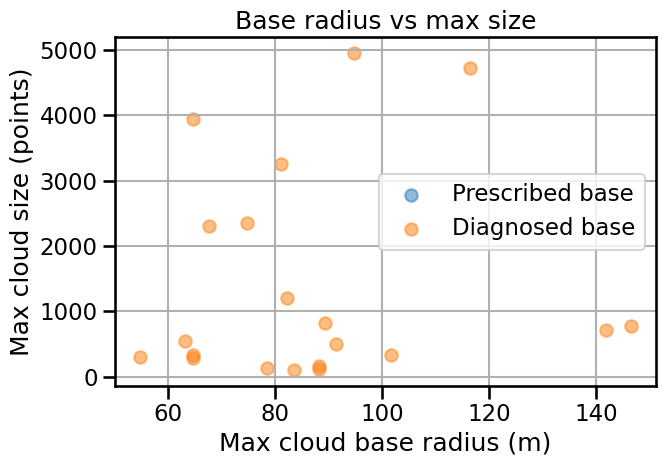

In [13]:
def extract_base_radii(raw, df_tracks):
    """
    Extract max prescribed and diagnosed base radii and top height for each track.
    Handles missing or malformed arrays gracefully.
    """
    # Defensive extraction
    prescribed = raw.get('base_radius_prescribed', None)
    diagnosed = raw.get('base_radius_diagnosed', None)
    top_height = raw.get('max_height', None)

    # Ensure arrays are present and have correct shape
    def safe_extract(arr, idx):
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            # Problem: array missing or not 2D
            # Risk: downstream IndexError, all NaN output
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Defensive: bounds check
        if arr.shape[0] < np.max(idx) + 1:
            # Problem: array too short for track indices
            # Risk: IndexError, incomplete extraction
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Extract max over time for each track
        return np.nanmax(arr[idx, :], axis=1)

    idx = df_tracks.track_index.values
    max_prescribed = safe_extract(prescribed, idx)
    max_diagnosed = safe_extract(diagnosed, idx)
    max_top_height = safe_extract(top_height, idx)
    return max_prescribed, max_diagnosed, max_top_height

max_prescribed, max_diagnosed, max_top_height = extract_base_radii(raw, df_tracks)

# Compute areas
area_prescribed = np.pi * max_prescribed**2
area_diagnosed = np.pi * max_diagnosed**2

# Relationship 1: base area vs max cloud top height
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, max_top_height, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, max_top_height, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (m²)")
plt.ylabel("Max cloud top height (m)")
plt.title("Base area vs max top height")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 2: base area vs total mass flux (normalized by lifespan)
norm_mass_flux = df_tracks.mass_flux_metric / df_tracks.lifetime
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, norm_mass_flux, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, norm_mass_flux, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (m²)")
plt.ylabel("Total mass flux / lifetime")
plt.title("Base area vs normalized mass flux")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 3: base radius vs max size
plt.figure(figsize=(7,5))
plt.scatter(max_prescribed, df_tracks.max_size_points, alpha=0.5, label='Prescribed base')
plt.scatter(max_diagnosed, df_tracks.max_size_points, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base radius (m)")
plt.ylabel("Max cloud size (points)")
plt.title("Base radius vs max size")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

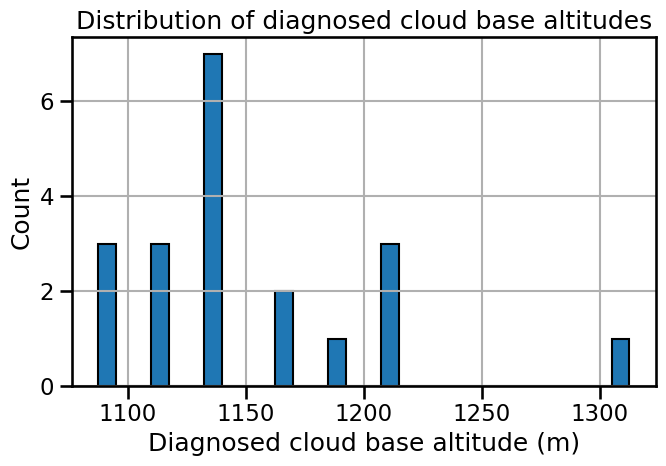

In [14]:
base_altitude = np.ma.filled(raw.get('cloud_base_height', None), np.nan)
idx = df_tracks.track_index.values
min_base_altitude = np.nanmin(base_altitude[idx, :], axis=1)
plt.figure(figsize=(7,5))
plt.hist(min_base_altitude[~np.isnan(min_base_altitude)], bins=30, edgecolor='black')
plt.xlabel("Diagnosed cloud base altitude (m)")
plt.ylabel("Count")
plt.title("Distribution of diagnosed cloud base altitudes")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#  trying to make this work (use the w per level and extract whats needed from there!)
#
# relationship between max cloud base w and max cloud size (and max cloud top height, and max branchiness)